In [1]:
from time import time
import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import gaussian_filter

from mesostat.metric.metric import MetricCalculator

import mesostat.metric.sequence as sequence
import mesostat.stat.resampling as resampling

%load_ext autoreload
%autoreload 2

In [2]:
gau = lambda mu, s2: np.exp(-(mu**2)/s2/2) / np.sqrt(2 * np.pi * s2)

## Part 1. Example usage

Have 3 channels with following profiles in time:
* $y_1(t) = \mathcal{N}(\mu=0.3)$
* $y_2(t) = \mathcal{N}(\mu=0.7)$
* $y_3(t) = U(\mu=0.5)$

Expect following order: $\mu_1 < \mu_3 < \mu_2$

Observing orderability matrix we conclude that the value of cell denotes if column is earlier than row:
* If $M_{ij} < 0$, then $\mu_j < \mu_i$
* If $M_{ij} > 0$, then $\mu_j > \mu_i$

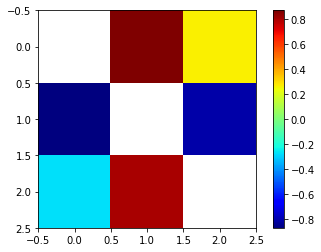

In [19]:
nTime = 100
nTrial = 30

x = np.linspace(0, 1, nTime)

# Generate template arrays
y1 = gau(x - 0.3, 0.2)
y2 = gau(x - 0.7, 0.2)
y3 = np.random.normal(0, 1, nTime)

# Extrude templates along trials
y1 = np.repeat([y1], nTrial, axis=0)
y2 = np.repeat([y2], nTrial, axis=0)
y3 = np.repeat([y3], nTrial, axis=0)

# Join into single dataset
yTot = np.array([y1, y2, y3])

# Add noise
yTot += np.random.normal(0, 1, (3, nTrial, nTime))

# Evaluate orderability and plot
mc = MetricCalculator(serial=True, verbose=False)
mc.set_data(yTot, 'prs')
rez = mc.metric3D('ord_binary', '', metricSettings={"directed" : True}, sweepSettings=None)

plt.figure()
plt.imshow(rez, cmap='jet')
plt.colorbar()
plt.show()

# Part 1: Generate some orderable data

In [5]:
nTrials = 100
nChannels = 40
nTimes = 300

### Model 1: 10 Cells consistently fire in fixed points, 30 random

In [6]:
data = np.zeros((nTrials, nChannels, nTimes))

times2D = np.outer(np.ones(nTrials), np.arange(nTimes))
for iChannel in range(10):
    mu = np.random.uniform(0, nTimes)
    s2 = np.random.uniform(50, 300)
    data[:, iChannel] = gau(times2D - mu, s2)

### Model 2: A sequence is of the same length as trial, but cycled

In [7]:
muVec = np.linspace(0, nTimes, nChannels)
s2Vec = 10 * np.ones(nChannels)
for iChannel in range(nChannels):
    data[0, iChannel] = gau(np.arange(nTimes) - muVec[iChannel], s2Vec[iChannel])
    
for iTrial in range(1, nTrials):
    cycleIdx = np.random.randint(0, nTimes)
    data[iTrial] = np.concatenate((data[0, :, cycleIdx:], data[0, :, :cycleIdx]), axis=1)

### Model 3: Cells form 3 clusters. Each cluster has a preferred firing time

In [8]:
nCluster = 3
clusterMeans = np.linspace(0.1, 0.9, nCluster)
nNodePerCluster = 30
nChannels = nNodePerCluster * nCluster
nTrials = nCluster * nNodePerCluster

data = np.zeros((nTrials, nChannels, nTimes))

print(clusterMeans)

times = np.linspace(-1, 2, nTimes)
for iCluster in range(nCluster):
    clusterMean = clusterMeans[iCluster]
    for iTrial in range(nTrials):
        for iCellCluster in range(nNodePerCluster):
            iCell = iCellCluster + nNodePerCluster * iCluster
            
            cellMean = -1
            while (cellMean < 0) or (cellMean > 1):
                cellMean = np.random.normal(clusterMean, 0.1)
            data[iTrial, iCell] = gau(times - cellMean, 0.1)

[0.1 0.5 0.9]


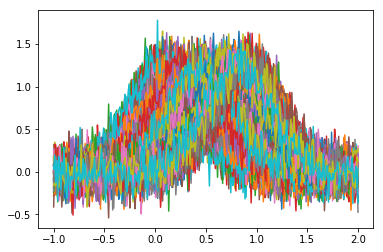

In [12]:
# Add some noise
data += np.random.normal(0,0.1,(nTrials, nChannels, nTimes))

plt.figure()
plt.plot(times, data[0].T)
plt.show()

## Binary Orderability

### Step 1. Comparison between two time-signals

Goal: Define a function $F : (\mathbb{R}^n, \mathbb{R}^n) \rightarrow \mathbb{R}$ that maps a pair of two time-signals onto a single floating-point number, which determines which signal was earlier, and by how much

If we can represent each metric by a time-dependent pmf, then we can calculate who is earlier by subtracting their CDF's. Note that we also normalize the CDF's is to make the test statistic (to some extent) comparable for trials of different length.

**Lemma 1:** Average value of a CCDF is equal to mean

$$\mathrm{AVG}(\mathrm{CDF}(p))
    = \frac{1}{n} \sum_{i=0}^{n-1} \sum_{j=0}^{i} p_i
    = \frac{1}{n} \sum_{i=0}^{n-1} (n-i) p_i
    = 1 - \mu_p$$
    
$$\mathrm{AVG}(\mathrm{CCDF}(p)) = 1 - \mathrm{AVG}(\mathrm{CDF}(p)) = \mu$$

**Lemma 2:** Average difference of CCDF's is equal to the difference of means

$$
\begin{eqnarray}
\Delta(p_1, p_2)
  &=& AVG(CCDF(p_1) - CCDF(p_2)) \\
  &=& AVG(CCDF(p_1)) - AVG(CCDF(p_2)) \\
  &=& \mu_1 - \mu_2
\end{eqnarray}
$$

**Metric:** In the binary scenario, we are only interested which signal is earlier, not by how much. This property can be evaluated by the following function

$$T_{\infty}(p_1, p_2) = \Delta(p_1, p_2) > 0 = \mu_1 > \mu_2$$


### Step 2. Bivariate Binary orderability, test

1. Evaluate T for each trial. Let $N$ denote the number of trials
2. Compute $N^{>}_{ij} = \sum_{k=0}^{N-1} T_{\infty}(p^k_i, p^k_j)$
3. Define binary orderability $BO_{ij} = \bigl|2\frac{N^{>}_{ij}}{N} - 1 \bigr|$
 * A non-negative number $\in [0,1]$
 * Monotonically increases from completely unorderable $0$ to completely unorderable $1$
4. $BO_{ij}$ can be tested for significance against NULL hypothesis, where $N_{>} \sim Bin(N, p=0.5)$

### Step 3. Average Binary orderability, test

1. Compute pairwise $N^{<}_{ij}$ for $i \neq j$
2. Compute pairwise $BO_{ij}$ matrix (excl. diagonal)
3. Define average binary orderability $ABO = AVG(OFFDIAG(BO))$
4. Empirical distribution for $ABO$ is non-trivial because if $A > B$, then it is more likely than not that $A > C$ for a random $A,B,C$. So it is not enough to consider all pairs independent when computing $ABO$ under NULL. Instead, $ABO$ can be tested for significance using one of the versions of bootstrap
  * Multiple random data of same shape
  * Permute channels for each trial
  * Cycle each time-trace by random period

### Open Questions:

* Another test could use $T$ directly, instead of $T_{bin}$?
    - Advantage: Try to filter out too small shifts and only focus on significant ones (maybe not even meaningful for low sampling rates)
    - Disadvantage: Result will be a mixture of frequency and magnitude
    - Disadvantage: There will be no null model, will need to use permutation test
    - Disadvantage: Since baseline would depend on temporal structure, there will be no reference baseline and trials from different animals may not be directly comparable.
* Any chance for analytical form of distr. of $ABO$ under NULL hypothesis?
* Orderability mean appears invariant of number of cells, the variance seems to decrease. It may be possible that null model is a gaussian with variance dropping as $nCell^{-0.5}$. If this is proven to be the case, can replace resampling with ERF and save much time. But not urgent at the moment

In [10]:
def resample_null(data):
    return np.random.uniform(0, 1, data.shape)

# Permute all channels for each trial separately
def resample_perm(data):
    return np.array([resampling.permutation(d, axis=0) for d in data])

# Cycle each time-trace by fixed amount
def resample_cycling(data):
    return np.array([resampling.cycling(d, axis=1) for d in data])

resampleMethodsDict = {
    "null" : resample_null,
    "perm" : resample_perm,
    "cycle" : resample_cycling
}

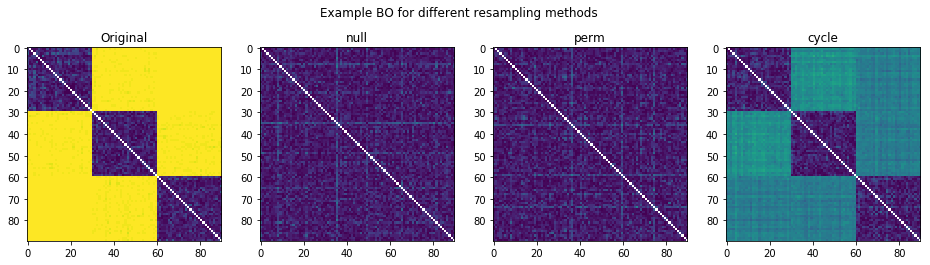

Started calc null
Finished in 120.35140180587769; Based on nSample 100 p-value estimated to 0.0
Started calc perm
Finished in 117.47585272789001; Based on nSample 100 p-value estimated to 0.0
Started calc cycle
Finished in 117.30236220359802; Based on nSample 100 p-value estimated to 0.0


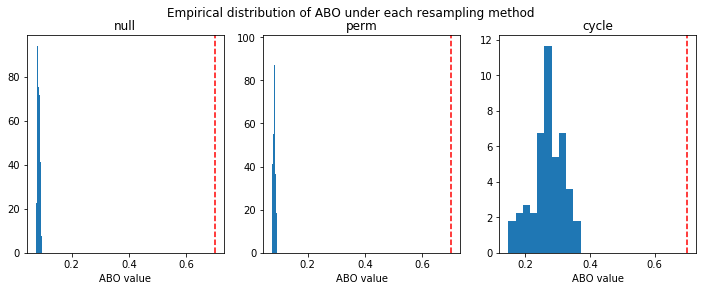

In [13]:
metricSettings = {'dim_order' : 'rps'}

# mc = MetricCalculator()
# mc.set_data(data, metricSettings['dim_order'])
# mu, var = mc.metric3D("ord_moments", "p").T
# print(np.sqrt(var))

# plt.figure()
# plt.errorbar(np.arange(nChannels), mu, np.sqrt(var))
# plt.show()

fig, ax = plt.subplots(ncols=4, figsize=(16,4))
fig.suptitle("Example BO for different resampling methods")
ax[0].imshow(sequence.bivariate_binary_orderability_3D(data, metricSettings), vmin=0, vmax=1)
ax[0].set_title('Original')

for i, (methodName , methodFunc) in enumerate(resampleMethodsDict.items()):
    dataRes = methodFunc(data)
    ax[i+1].imshow(sequence.bivariate_binary_orderability_3D(dataRes, metricSettings), vmin=0, vmax=1)
    ax[i+1].set_title(methodName)

plt.show()


nSample = 100
fig, ax = plt.subplots(ncols=3, figsize=(12,4))
fig.suptitle("Empirical distribution of ABO under each resampling method")

test_stat_wrapper = lambda data : sequence.avg_bivariate_binary_orderability_3D(data, metricSettings)
resTrue = test_stat_wrapper(data)

for i, (methodName , methodFunc) in enumerate(resampleMethodsDict.items()):
    print("Started calc", methodName)
    t1 = time()
    resampledDataLst = resampling.resample_monad(test_stat_wrapper, data, methodFunc, nSample)
    print("Finished in", time() - t1, end="; ")
    print("Based on nSample", nSample, "p-value estimated to", np.mean(resampledDataLst > resTrue))
    
    ax[i].hist(resampledDataLst, bins='auto', density=True)
    ax[i].axvline(x=resTrue, color='r', linestyle='--')
    ax[i].set_title(methodName)
    ax[i].set_xlabel("ABO value")
    
plt.show()

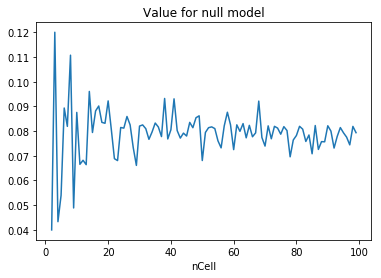

In [48]:
nCellLst = np.arange(2, 100)
resultLst =[]
for nCell in nCellLst:
    dataTest = np.random.uniform(0, 1, (nTrials, nCell, nTimes))
    resultLst += [test_stat_wrapper(dataTest)]
    
plt.figure()
plt.title("Value for null model")
plt.xlabel("nCell")
plt.plot(nCellLst, resultLst)
plt.show()

## Orderability - Take 2

**Questions**:
1. How to represent center where stuff is under mono-modal assumption
   * For signle trial
   * For multiple trials
2. How to check if one stuff is earlier than another
   * For single trial
   * For multiple trials
3. How to define orderability of a population
4. How to proceed relaxing mono-modality assumption

### Step 1. Mono-Modal representation

We measure a signal $x(t)$ for $N$ time steps. We will assume that
* $x(t) \geq 0 \; \forall t$. If this is not the case, a baseline, e.g. minimum of the signal, can be subtracted prior to this analysis.
* $x(t)$ is a mono-modal signal, namely, that the signal is concentrated around a certain time and falls down smoothly from there.

If the signal is too positive or too negative, it may be possible to normalize it. While it is totally unclear what the optimal way of doing this is, the simplest way could be to subtract the minimum

$$x(t) \rightarrow \frac{x(t) - x_{\min}}{x_{\max} - x_{\min}}$$

Under these assumptions, it is clear that the simplest way to represent the temporal characteristics of the signal is by calculating its mean and variance. Namely, we define the probability distribution
$$p(t) = \frac{x(t)}{\sum_{t=1}^N x(t)}$$
Then we can proceed to define the mean and variance of this probability distribution
$$
\begin{eqnarray}
\mu(p) &=& \langle t \rangle_p = \sum_{t=1}^N t \cdot p(t) \\
\sigma^2(p) &=& \langle (t - \mu)^2 \rangle_p = \langle t^2 \rangle_p - \mu^2 = \sum_{t=1}^N t^2 p(t) - \mu^2
\end{eqnarray}
$$

$$\sigma^2(p) = \sum_{t=1}^N t^2 p(t) - \mu^2$$

Further, we want to compute length-invariant metrics to make them comparable for trials of unequal length. For this, we rescale the initial interval to $[0, 1]$. As a result, our metrics get rescaled to $\tilde{\mu} = \frac{\mu}{N}$, $\tilde{\sigma}^2 = \frac{\sigma^2}{N^2}$

Finally, we want to accumulate our observation over multiple trials. If a single observation is given by
$$x_i \sim \mathcal{N}(\mu_{p_i}, \sigma^2_{p_i})$$
then we seek the distribution of the average of those observations
$$AVG(\vec{x}) \sim \mathcal{N}(\mu_{tot}, \sigma^2_{tot})$$
The average of random normal variables is a well-known result
$$(\mu_{tot}, \sigma^2_{tot}) = (AVG(\mu_p), AVG(\sigma^2_p))$$

Note, that there are two different sources of variability, 
* $AVG(\sigma^2_p)$ - the average compactness of stuff within a trial, disregarding the variance of the means
* $VAR(\mu_p)$ - the average compactness of stuff across trials

In general, there is more than one way to reconcile these two types of variability. But, for normal approximation they happen to coincide.

### Step 2. Orderability

Given two random variables, we want to see if one of them is likely to be smaller than the other, or if we are undecided. This question is equivalent to checking if the difference between the two variables is significantly different from zero or not. Thus

$$\Delta_{ij} = x_i - x_j \sim \mathcal{N} (\mu_i - \mu_j, \sigma^2_i + \sigma^2_j)$$

Now, the significance of this difference can be represented either by the t-test statistic

$$T_{ij} = \frac{\mu_i - \mu_j}{\sqrt{\frac{\sigma^2_i + \sigma^2_j}{2}}}$$

or the associate p-value. Note that the p-value in this case serves only as a metric to evaluate the difference, not in its original interpretation of statistical significance. It could only be interpreted in that way if the assumptions underlying the construction of the mono-modal probability representation actually held, and they most certainly don't in practice. Still, this metric can prove useful to discriminate between, e.g., several experimental conditions, under which the order of cellular activations may significantly change.

T-test statistic and associated p-value naturally extend to multiple trials.

### Step 3. Average Orderability

What would be a good scalar metric of orderability of the entire population, given a matrix of associated test statistics or p-values. **Brainstorm**
* Average absolute value test-statistic
* Geometric average p-value


### Step 4. Relaxing mono-modal assumption

Mono-modal assumption

### TODO:

**Potential Pitfalls**:
* Linear scaling with temporal distance may not be the best. If the traces are clearly separable, we do not care how far away their means are. So having means very far can significantly increase the mean distance, while providing no additional disctiminatory power. It may make sense to crop tscore values to some maximal allowed value.


True in [-5.6736236632229025, 6.058945990514473]
null in [-2.2544295503555385, 1.716916034421757]
perm in [-8.899261063953762, 9.035428191459161]
cycle in [-2.9791866009095855, 2.212127592340062]


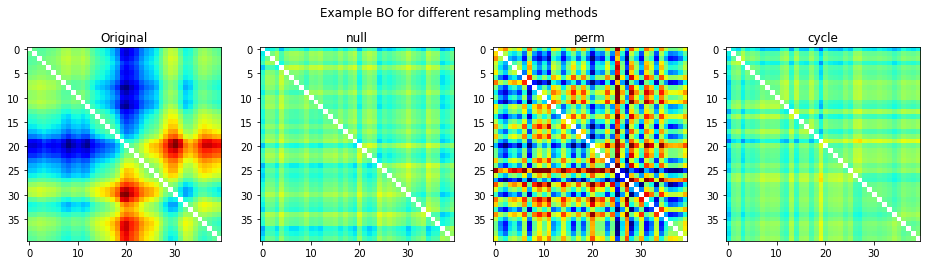

Started calc null
Finished in 54.25020956993103; Based on nSample 100 p-value estimated to 1.0
Started calc perm
Finished in 54.74659824371338; Based on nSample 100 p-value estimated to 0.03
Started calc cycle
Finished in 57.38057589530945; Based on nSample 100 p-value estimated to 1.0


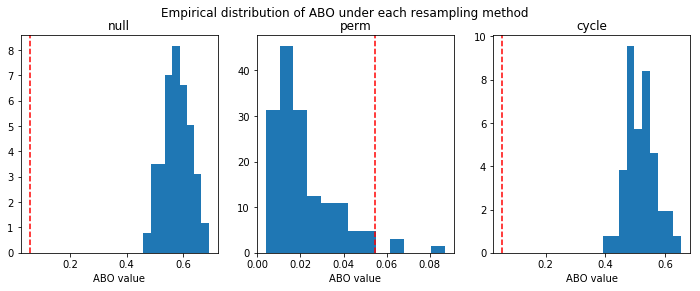

In [18]:
metricSettings = {'dim_order' : 'rps'}
rezTrue = sequence.bivariate_student_orderability_3D(data, metricSettings)
trueMin = np.nanmin(rezTrue)
trueMax = np.nanmax(rezTrue)
print("True in", [trueMin, trueMax])


fig, ax = plt.subplots(ncols=4, figsize=(16,4))
fig.suptitle("Example BO for different resampling methods")
ax[0].imshow(rezTrue, cmap='jet')
ax[0].set_title('Original')

for i, (methodName , methodFunc) in enumerate(resampleMethodsDict.items()):
    dataRes = methodFunc(data)
    rezThis = sequence.bivariate_student_orderability_3D(dataRes, metricSettings)
    thisMin = np.nanmin(rezThis)
    thisMax = np.nanmax(rezThis)
    print(methodName, "in", [thisMin, thisMax])
    
    ax[i+1].imshow(rezThis, cmap='jet', vmin=trueMin, vmax=trueMax)
    ax[i+1].set_title(methodName)

plt.show()


nSample = 100
fig, ax = plt.subplots(ncols=3, figsize=(12,4))
fig.suptitle("Empirical distribution of ABO under each resampling method")

test_stat_wrapper = lambda data : sequence.avg_bivariate_student_orderability_3D(data, metricSettings)
resTrue = test_stat_wrapper(data)

for i, (methodName , methodFunc) in enumerate(resampleMethodsDict.items()):
    print("Started calc", methodName)
    t1 = time()
    resampledDataLst = resampling.resample_monad(test_stat_wrapper, data, methodFunc, nSample)
    print("Finished in", time() - t1, end="; ")
    print("Based on nSample", nSample, "p-value estimated to", np.mean(resampledDataLst > resTrue))
    
    ax[i].hist(resampledDataLst, bins='auto', density=True)
    ax[i].axvline(x=resTrue, color='r', linestyle='--')
    ax[i].set_title(methodName)
    ax[i].set_xlabel("ABO value")
    
plt.show()

# 3. Testing consistency of Studend Orderability

Original (mean, std) 29.997560842184434 5.000000547486467
Noisy (mean, std) 29.999234188160905 14.611544489434666
Filtered (mean, std) 30.00170941655108 7.173083582606727
Original Taxicab 3.2582499799172946
Noisy Taxicab 3.2464227533661463
Filtered Taxicab 4.331364236806653


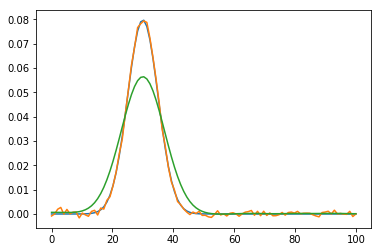

In [6]:
def make_p(y, base):
    p = y - base
    p[p < 0] = 0
    return p / np.sum(p)

def moments(x, y):
    # Estimate mean
    p = make_p(y, np.mean(y))
    mu = p.dot(x)
    
    # Estimate variance
    xZero = x - mu
    p = make_p(y, np.min(y))
    std = np.sqrt(p.dot(xZero**2))
    return mu, std
    
def moment_taxicab(x, y):
    # Estimate mean
    p = make_p(y, np.mean(y))
    mu = p.dot(x)
    
    # Estimate variance
    taxicab = p.dot(np.abs(x - mu))
    return taxicab

x = np.linspace(0, 100, 100)
y = gau(x - 30, 5**2)
ynoisy = y + np.random.normal(0, 0.001, 100)

stdFilter = 5
yfiltered = gaussian_filter(ynoisy, stdFilter)

mu, std = moments(x, y)
muNoisy, stdNoisy = moments(x, ynoisy)
muFiltered, stdFiltered = moments(x, yfiltered)
taxicabRaw = moment_taxicab(x, y)
taxicabNoisy = moment_taxicab(x, ynoisy)
taxicabFiltered = moment_taxicab(x, yfiltered)

print("Original (mean, std)", mu, std)
print("Noisy (mean, std)", muNoisy, stdNoisy)
print("Filtered (mean, std)", muFiltered, np.sqrt(stdFiltered**2 - stdFilter**2))
print("Original Taxicab", taxicabRaw)
print("Noisy Taxicab", taxicabNoisy)
print("Filtered Taxicab", taxicabFiltered)

plt.figure()
plt.plot(x, y)
plt.plot(x, ynoisy)
plt.plot(x, yfiltered)
plt.show()
